### Supervised machine learning
In this notebook we will continue working on the data and attempt to classify areas through supervised machine learning. Supervised learning requires some ground truth to validate on. However, on this data set there is no real ground truth available. For the sake of testing the methodology, a ground truth has been derived and is used in these examples. Therefore the result is to be taken lightly. However, if you do apply this method to data where you have actual ground truth data available, this should work just fine for you.

In [1]:
from glob import glob
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import matplotlib as mpl
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
import rasterio as rasterio
import matplotlib.pyplot as plt
import numpy as np
import os
import sklearn
import pickle

from sklearnex import patch_sklearn # Speeds up the classifiers when on an intel CPU
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Load images that has already been sliced and diced in SNAP toolbox

#path = '../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/larger/'
path = '../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium/'

s2_bands = glob(path+'*B*.tif')
s2_bands.sort()

print('Showing all loaded bands, the order they are loaded in and array identifier:')
for ix, ls in enumerate(s2_bands):
    print(ls + f', Array ID [{ix}]')

# Load all bands and stack them in a np array
img = []

for i in s2_bands:
    #print(i)
    with rasterio.open(i, 'r') as f:
        img.append(f.read(1))
        
arr_st = np.stack(img)

Showing all loaded bands, the order they are loaded in and array identifier:
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B01.tif, Array ID [0]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B02.tif, Array ID [1]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B03.tif, Array ID [2]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B04.tif, Array ID [3]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B05.tif, Array ID [4]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B06.tif, Array ID [5]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B07.tif, Array ID [6]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B08.tif, Array ID [7]
../../Optical/Vegetation_ML/images_tiff/resampled/geotiff/medium\subset_resampled_B09.tif, 

With the data loaded in, we can begin a few reshaping operations to preprocess the data
*Note that Band 10 has been excluded in this exercise compared to the previous*

In [3]:
print(f'Height: {arr_st.shape[1]}\nWidth: {arr_st.shape[2]}\nBands: {arr_st.shape[0]}')

Height: 1526
Width: 1976
Bands: 12


In [4]:
x = np.moveaxis(arr_st, 0, -1)
x.shape

(1526, 1976, 12)

In [5]:
from sklearn.preprocessing import StandardScaler

X_data = x.reshape(-1, 12)

scaler = StandardScaler().fit(X_data)

X_scaled = scaler.transform(X_data)

X_scaled.shape

(3015376, 12)

### Ground truth data
Since there are no ground truth data available for this region, I have taken the extreme liberty of using the ground truth derived from the previous notebook by classifying the NDVI data. This is wrong, but the closest available approximation and will do for the sake of this example. 

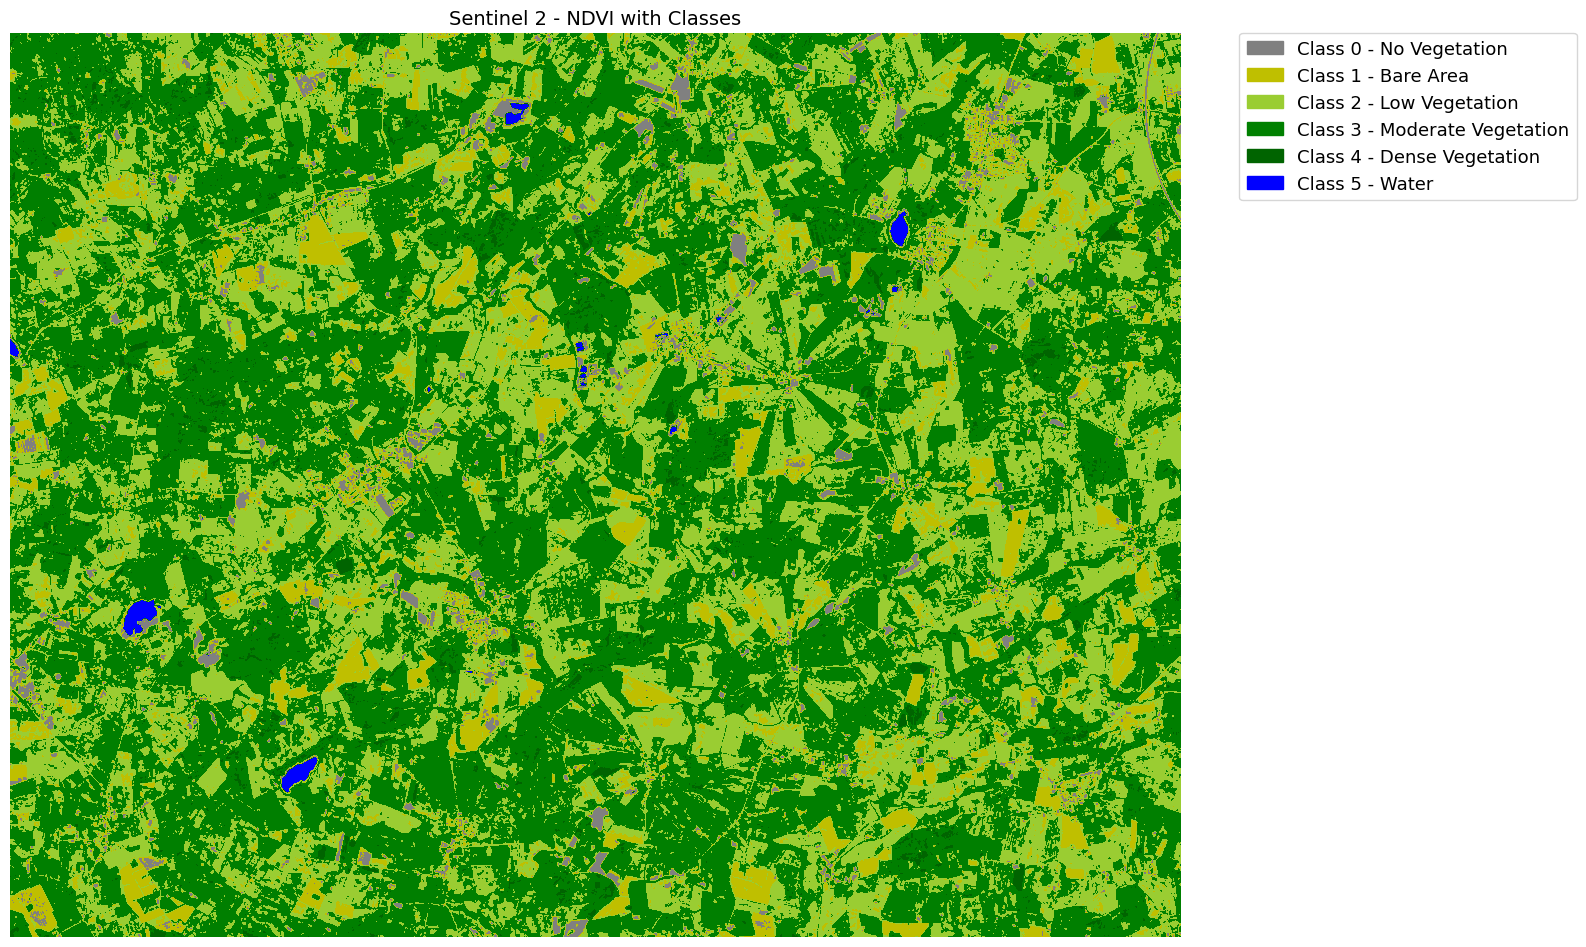

In [6]:
# Generating "ground truth" map off the NDVI parameters
#ndvi = es.normalized_diff(arr_st[7], arr_st[3])
ndvi = ( (arr_st[7]-arr_st[3])/(arr_st[7]+arr_st[3]) )
ndvi_class_bins = [-np.inf, 0, 0.15, 0.25, 0.4, 0.6, 1.0, np.inf]
ndvi_sent_class = np.digitize(ndvi, ndvi_class_bins)
ndvi_sent_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_sent_class
)
np.unique(ndvi_sent_class)

# Define color map
nbr_colors = ["gray", "y", "yellowgreen", "g", "darkgreen", 'blue']
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Class 0 - No Vegetation",
    "Class 1 - Bare Area",
    "Class 2 - Low Vegetation",
    "Class 3 - Moderate Vegetation",
    "Class 4 - Dense Vegetation",
    "Class 5 - Water",
]

# Get list of classes
classes = np.unique(ndvi_sent_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:6]

# Plot your data
fig, ax = plt.subplots(figsize=(16, 16))
im = ax.imshow(ndvi_sent_class, cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Sentinel 2 - NDVI with Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()

In [7]:
y_data = ndvi_sent_class
y_data.shape

(1526, 1976)

### Train - Test split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_data.ravel(), test_size=0.30, stratify = y_data.ravel())

print(f'X_train Shape: {X_train.shape}\nX_test Shape: {X_test.shape}\ny_train Shape: {y_train.shape}\ny_test Shape:{y_test.shape}')

X_train Shape: (2110763, 12)
X_test Shape: (904613, 12)
y_train Shape: (2110763,)
y_test Shape:(904613,)


### K-Nearest Neighbor classifier

In [9]:
save_model  = 1 ## Save a new model
load_model  = 0 ## Load an existing model


data_folder = "..Vegetation_ML"
dmodel = (data_folder+'/saved_models/{}_model.sav')

print(dmodel)

C:/Users/Kongs/OneDrive/Geoscience/Post-University/Remote sensing and GIS/Programming/Optical/Vegetation_ML/saved_models/{}_model.sav


In [10]:
if save_model:
    ## Include the above cell when its finished
    from sklearn.neighbors import KNeighborsClassifier

    knn = KNeighborsClassifier(n_neighbors=6)
    knn.fit(X_train, y_train)

    knn_pred = knn.predict(X_test)
    
    print('Model saved as: ', dmodel.format('knn_red'))
    pickle.dump(knn_pred, open(dmodel.format('knn_pred'), 'wb'))
    print('File size: ',round((os.stat(dmodel.format('knn_pred')).st_size)/(10**3),2), 'kb')

Model saved as:  C:/Users/Kongs/OneDrive/Geoscience/Post-University/Remote sensing and GIS/Programming/Optical/Vegetation_ML/saved_models/knn_red_model.sav
File size:  7237.07 kb


In [11]:
## If the model has already been run and saved, it can be loaded here much faster

if load_model:
    print('Loading saved model: ', dmodel.format('knn_pred'))
    knn_pred = pickle.load(open(dmodel.format('knn_pred'), 'rb'))

In [12]:
print(f"Accuracy: {accuracy_score(y_test, knn_pred)*100}")

Accuracy: 96.46622367797058


In [13]:
print(classification_report(y_test, knn_pred))

              precision    recall  f1-score   support

           2       0.89      0.91      0.90     16123
           3       0.91      0.92      0.92     67694
           4       0.95      0.97      0.96    330156
           5       0.98      0.97      0.98    478439
           6       0.95      0.83      0.88      9999
           7       0.94      0.91      0.93      2202

    accuracy                           0.96    904613
   macro avg       0.94      0.92      0.93    904613
weighted avg       0.96      0.96      0.96    904613



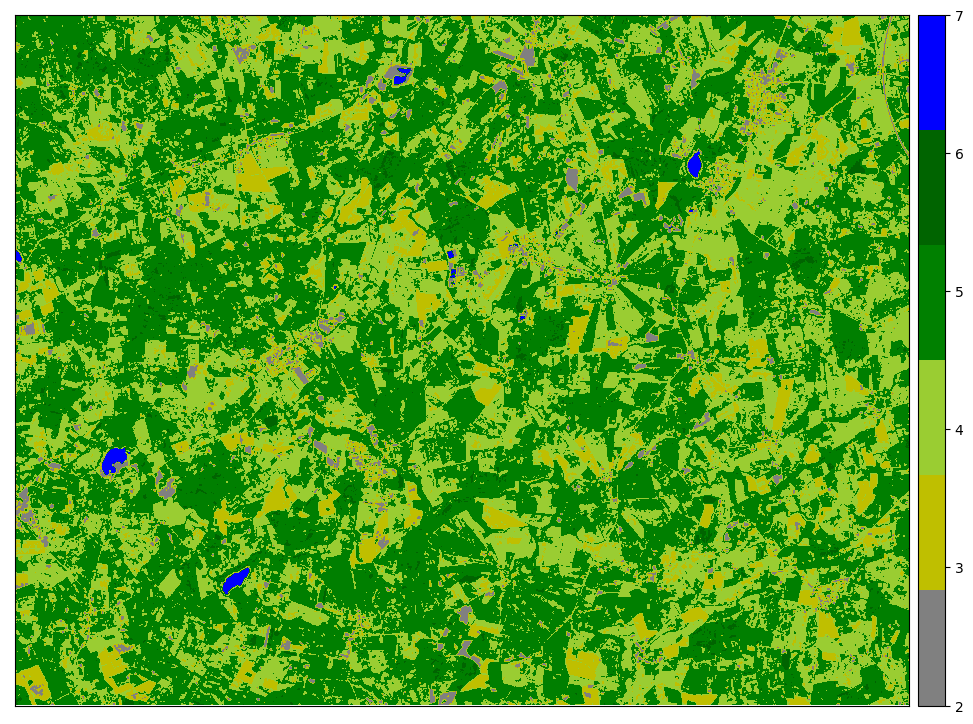

In [14]:
# Visualize Classification Map of K-NNC

ep.plot_bands(knn.predict(X_scaled).reshape((1526, 1976)), 
              cmap=ListedColormap(["gray", "y", "yellowgreen", "g", "darkgreen", 'blue']))
plt.show()

Figure 1 - NDVI estimated classes  Figure 2 - K-NNC classification


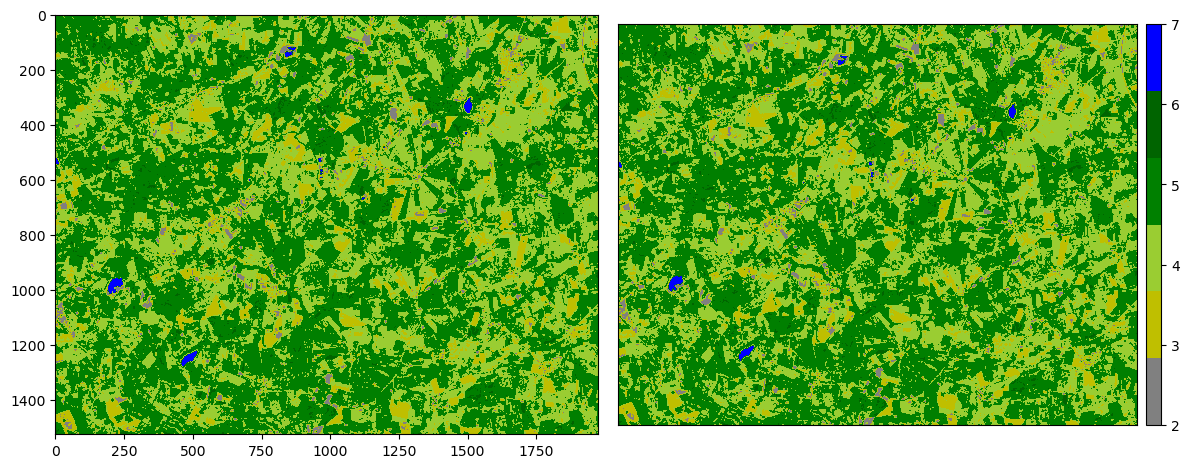

In [15]:
## Plotting the two side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 12))
ndvi[ndvi > 1] = -1 #For better seing water


ax1 = ax1.imshow(ndvi_sent_class, cmap=nbr_cmap)
#ep.draw_legend(im_ax=ax1, classes=classes, titles=ndvi_cat_names)
ax2 = ep.plot_bands(knn.predict(X_scaled).reshape((1526, 1976)), cmap=ListedColormap(["gray", "y", "yellowgreen", "g", "darkgreen", 'blue']), ax=ax2)
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
# Auto adjust subplot to fit figure size
plt.tight_layout()
print('Figure 1 - NDVI estimated classes ', 'Figure 2 - K-NNC classification')

### Evaluating KNN classifier
If we take a look at the metrics it shows us a very accurate prediction of the classes. Class 2 and 6 are performing the worst, but is still sitting at 90% and 89%, which is still very well. As seen in the two subplot aboves, it is difficult to notice the difference. The high accuracy is expected as the model is: 
1) Trained 70%/30% on artificial ground truth derived by binning values on the NDVI plot
2) The model has not been validated on unseen data, which would undoubtly lower the score. I have covered validation of data in my repository on LiDAR data and will not get into it for now.

### Light GBM

In [16]:
import lightgbm as lgb

if save_model:

    d_train = lgb.Dataset(X_train, label=y_train)

    params={}
    params['learning_rate']=0.03
    params['boosting_type']='gbdt' #GradientBoostingDecisionTree
    params['objective']='multiclass' #Multi-class target feature
    params['metric']='multi_logloss' #metric for multi-class
    params['max_depth']=15
    params['num_leaves']=20
    params['num_class']=8 #no.of unique values in the target class not inclusive of the end value

    clf = lgb.train(params, d_train, 100)

    lgb_predictions = clf.predict(X_test)
    print('Model saved as: ', dmodel.format('lgb_pred'))
    pickle.dump(clf, open(dmodel.format('lgb_pred'), 'wb'))
    print('File size: ',round((os.stat(dmodel.format('lgb_pred')).st_size)/(10**3),2), 'kb')

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.030636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3060
[LightGBM] [Info] Number of data points in the train set: 2110763, number of used features: 12
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -34.538776
[LightGBM] [Info] Start training from score -4.027242
[LightGBM] [Info] Start training from score -2.592520
[LightGBM] [Info] Start training from score -1.007940
[LightGBM] [Info] Start training from score -0.636980
[LightGBM] [Info] Start training from score -4.505022
[LightGBM] [Info] Start training from score -6.017946
Model saved as:  C:/Users/Kongs/OneDrive/Geoscience/Post-University/Remote sensing and GIS/Programming/Optical/Vegetation_ML/saved_models/lgb_pred_model.sav
File size:  1432.16 kb


In [17]:
## If the model has already been run and saved, it can be loaded here much faster

if load_model:
    print('Loading saved model: ', dmodel.format('lgb_pred'))
    lgb_predictions = pickle.load(open(dmodel.format('lgb_pred'), 'rb'))

In [18]:
print(lgb_predictions[1], np.argmax(lgb_predictions[1]))

[1.04588795e-16 1.04588795e-16 1.37021571e-04 5.51370765e-04
 2.27518503e-03 9.96934004e-01 8.36511183e-05 1.87679537e-05] 5


In [19]:
lgb_pred = np.argmax(lgb_predictions, axis=1)
print(lgb_pred.shape)

(904613,)


In [20]:
print(f"Accuracy: {accuracy_score(y_test, lgb_pred)*100}")

Accuracy: 99.3443605165966


In [21]:
print(classification_report(y_test, lgb_pred))

              precision    recall  f1-score   support

           2       0.94      0.93      0.94     16123
           3       0.97      0.98      0.98     67694
           4       0.99      1.00      1.00    330156
           5       1.00      1.00      1.00    478439
           6       0.97      0.96      0.96      9999
           7       0.93      0.88      0.90      2202

    accuracy                           0.99    904613
   macro avg       0.97      0.96      0.96    904613
weighted avg       0.99      0.99      0.99    904613



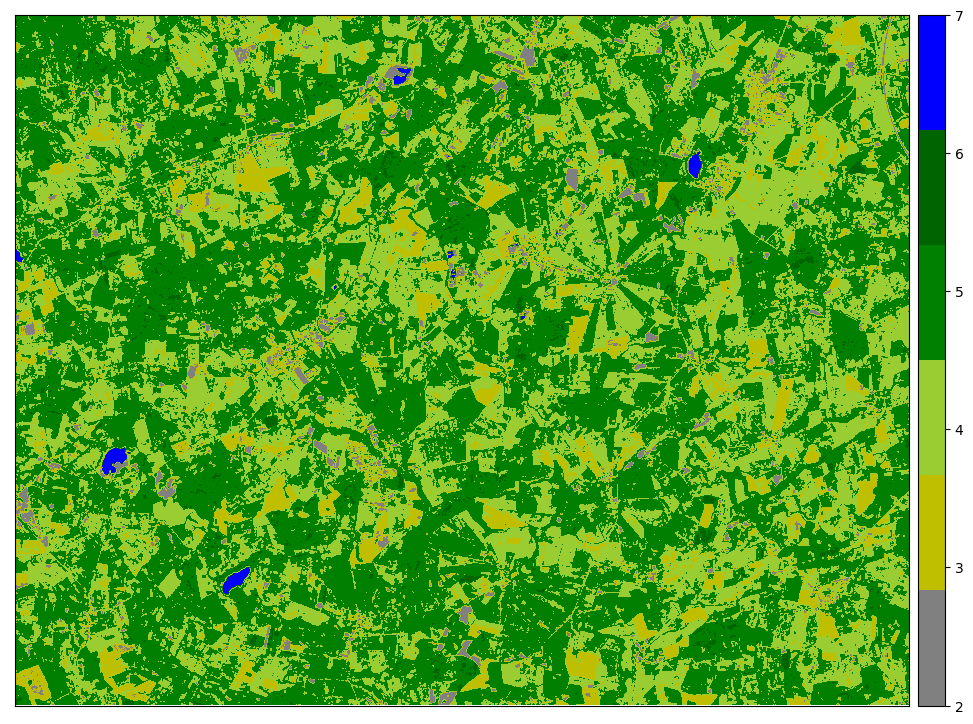

In [22]:
# Visualize Classification Map of LightGBM

ep.plot_bands(np.argmax(clf.predict(X_scaled), axis=1).reshape((1526, 1976)), 
              cmap=ListedColormap(["gray", "y", "yellowgreen", "g", "darkgreen", 'blue']))
plt.show()

Figure 1 - NDVI estimated classes  Figure 2 - Light GBM classification


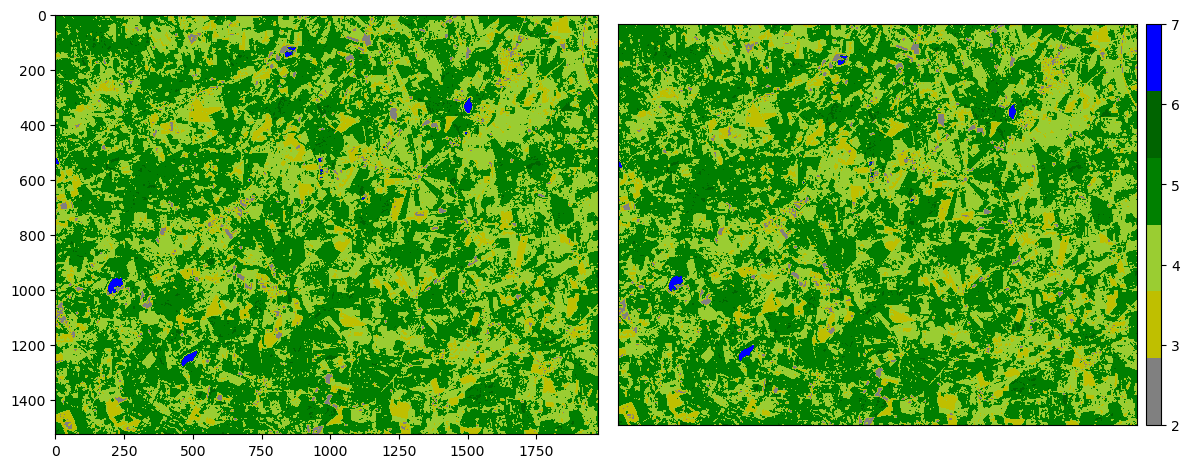

In [23]:
## Plotting the two side by side
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 12))
ndvi[ndvi > 1] = -1 #For better seing water


ax1 = ax1.imshow(ndvi_sent_class, cmap=nbr_cmap)
ax2 = ep.plot_bands(np.argmax(clf.predict(X_scaled), axis=1).reshape((1526, 1976)), 
              cmap=ListedColormap(["gray", "y", "yellowgreen", "g", "darkgreen", 'blue']), ax=ax2)
ax.axes.yaxis.set_ticklabels([])
ax.axes.xaxis.set_ticklabels([])
# Auto adjust subplot to fit figure size
plt.tight_layout()
print('Figure 1 - NDVI estimated classes ', 'Figure 2 - Light GBM classification')

### Evaluating Light GBM classifier
The Light GBM classifier provides an improved prediction result as seen by the metrics with an incredibly high accuracy. Again without validating the model on unseen data this metric will always be high.